# Numerické řešení konvekce s difusí pomocí MKO

## Síť pro MKO

In [1]:
using Plots
using StaticArrays
import Base.-, Base.+, Base.*, Base./
using ForwardDiff
using LinearAlgebra

pyplot();

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


In [2]:
const Scalar = Float64;
const Vector = SVector{2,Float64};
const Label  = Int;

In [3]:
×(u::Vector, v::Vector) = u[1]*v[2] - u[2]*v[1];

In [4]:
const ScalarList = Array{Scalar,1};
const VectorList = Array{Vector,1};
const LabelList  = Array{Label,1};
const LabelListList = Array{LabelList,1};

In [5]:
struct PatchInfo
    name  :: String
    range :: UnitRange{Label}
end;

const PatchInfoList = Array{PatchInfo,1};

In [6]:
struct Mesh
    point      :: VectorList     # Souradnice vrcholu site 
    centre     :: VectorList     # Souradnice stredu bunek 
    volume     :: ScalarList     # Velikosti (objemy) bunek
    surface    :: VectorList     # Normalovy vektor na stenu 
    facecentre :: VectorList     # Souradnice stredu strany
    owner      :: LabelList      # Vlastnik steny
    neighbor   :: LabelList      # Soused steny
    patch      :: PatchInfoList  # Seznam okrajovych podminek
    
    cell2point :: LabelListList  # Indexy vrcholu bunek
    face2point :: LabelListList  # Indexy vrcholu sten
end

"""
    Mesh(point, owner, neighbor, patch, cell2point, face2point)

    Vytvori sit ze zadanych souradnic vrcholu a informaci o konektivite
"""
function Mesh(point::VectorList, owner::LabelList, neighbor::LabelList, patch::PatchInfoList, cell2point::LabelListList, face2point::LabelListList)
    m = Mesh(point, VectorList(), ScalarList(), VectorList(), VectorList(), owner, neighbor, patch, cell2point, face2point)
    update!(m)
    return m
end

Mesh

In [7]:
"""
    update!(mesh::Mesh)

    Vypocte objemy bunek, souradnice stredu bunek, normalove vektory na steny a stredy sten.
"""
function update!(mesh::Mesh)

    # Recalculate cell centres & volumes
    ncells = size(mesh.cell2point,1)
    empty!(mesh.centre)
    empty!(mesh.volume)
    for c=1:ncells
        pts = mesh.point[mesh.cell2point[c]]
        
        v = Scalar(0)
        x = Vector(0,0)
        p1 = pts[end]
        for i=1:size(pts,1)-2
            p2 = pts[i]
            p3 = pts[i+1]
            vv = (p2 - p1) × (p3 - p1) / 2
            v += vv
            x += vv*(p1 + p2 + p3)/3
        end
        push!(mesh.volume, v)
        push!(mesh.centre, x/v)
    end
    
    # Recalculate face sizes & positions
    empty!(mesh.surface)
    empty!(mesh.facecentre)
    nfaces = size(mesh.face2point,1)
    for f=1:nfaces
        pts = mesh.point[mesh.face2point[f]]
        push!(mesh.surface, Vector(pts[2][2]-pts[1][2], pts[1][1]-pts[2][1]))
        push!(mesh.facecentre, (pts[1]+pts[2])/2)
    end 
end

update!

In [8]:
"""
    cartesian_mesh(nx, ny)

    Vytvori kartezskou sit o nx*ny bunkach v jednotkovem ctverci. Okrajove podminky pojmenuje "left", "right", "top" a "bottom"
"""
function cartesian_mesh(nx, ny)
    Δx, Δy = 1.0/nx, 1.0/ny
    
    pid(i,j) = i + j*(nx+1) + 1
    cid(i,j) = i + (j-1)*nx


    # Mesh points
    point = VectorList() 
    for j=0:ny, i=0:nx
        push!(point, Vector(i*Δx, j*Δy))
    end
    
    # Mesh cells
    cell2point = LabelListList()
    for j=1:ny, i=1:nx
        pts = [pid(i-1,j-1), pid(i,j-1), pid(i,j), pid(i-1,j)] |> LabelList
        push!(cell2point, pts)
    end
    
    # Mesh faces
    owner = LabelList()
    neighbor = LabelList()
    face2point = LabelListList()
    
    # Internal faces
    for j=1:ny, i=1:nx-1
        push!(owner, cid(i,j))
        push!(neighbor, cid(i+1,j))
        push!(face2point, [pid(i,j-1), pid(i,j)])
    end

    for j=1:ny-1, i=1:nx
        push!(owner, cid(i,j))
        push!(neighbor, cid(i,j+1))
        push!(face2point, [pid(i,j), pid(i-1,j)])
    end
    
    # Boundary patches
    # - bottom
    patch = PatchInfoList()
    j=0
    start = size(owner,1)+1
    for i=1:nx
        push!(owner, cid(i,j+1))
        push!(face2point, [pid(i-1,j), pid(i,j)])
    end
    push!(patch, PatchInfo("bottom", UnitRange(start, size(owner,1))))

    # - right
    i=nx
    start = size(owner,1)+1
    for j=1:ny
        push!(owner, cid(i,j))
        push!(face2point, [pid(i,j-1), pid(i,j)])
    end
    push!(patch, PatchInfo("right", UnitRange(start, size(owner,1))))
    
    # - top
    j=ny
    start = size(owner,1)+1
    for i=1:nx
        push!(owner, cid(i,j))
        push!(face2point, [pid(i,j), pid(i-1,j)])
    end
    push!(patch, PatchInfo("top", UnitRange(start, size(owner,1))))

    # - left
    i=0
    start = size(owner,1)+1
    for j=1:ny
        push!(owner, cid(i+1,j))
        push!(face2point, [pid(i,j), pid(i,j-1)])
    end
    push!(patch, PatchInfo("left", UnitRange(start, size(owner,1))))
    
    return Mesh(point, owner, neighbor, patch, cell2point, face2point)
end

cartesian_mesh

In [9]:
cells(m::Mesh) = UnitRange(1,length(m.volume))

internal_faces(m::Mesh) = UnitRange(1,length(m.neighbor))

boundary_patches(m::Mesh) = UnitRange(1,length(m.patch))

patch_names(m::Mesh) = [ m.patch[p].name for p in boundary_patches(m)]

patch_by_name(m::Mesh, name::String) = findfirst(x->x==name, patch_names(m))

patch_faces(m::Mesh, patch::Label) = m.patch[patch].range

patch_faces (generic function with 1 method)

In [10]:
m2 = cartesian_mesh(2,2);

In [11]:
for p in m2.point
    println("p = ", p)
end

p = [0.0, 0.0]
p = [0.5, 0.0]
p = [1.0, 0.0]
p = [0.0, 0.5]
p = [0.5, 0.5]
p = [1.0, 0.5]
p = [0.0, 1.0]
p = [0.5, 1.0]
p = [1.0, 1.0]


In [12]:
for c in m2.centre
    println("c = ", c)
end

print("volume[:] = ", m2.volume)

c = [0.25, 0.25]
c = [0.75, 0.25]
c = [0.25, 0.75]
c = [0.75, 0.75]
volume[:] = [0.25, 0.25, 0.25, 0.25]

In [13]:
for f in internal_faces(m2)
    println("S=", m2.surface[f], "\t o=", m2.owner[f], "\t n=",m2.neighbor[f])
end

S=[0.5, 0.0]	 o=1	 n=2
S=[0.5, 0.0]	 o=3	 n=4
S=[0.0, 0.5]	 o=1	 n=3
S=[0.0, 0.5]	 o=2	 n=4


In [14]:
for p in boundary_patches(m2)
    println("PATCH ", m2.patch[p].name)
    for f in patch_faces(m2, p)
        println("S=", m2.surface[f], "\t o=", m2.owner[f])
    end
    println()
end

PATCH bottom
S=[0.0, -0.5]	 o=1
S=[0.0, -0.5]	 o=2

PATCH right
S=[0.5, 0.0]	 o=2
S=[0.5, 0.0]	 o=4

PATCH top
S=[0.0, 0.5]	 o=3
S=[0.0, 0.5]	 o=4

PATCH left
S=[-0.5, 0.0]	 o=1
S=[-0.5, 0.0]	 o=3



## Uložení dat a okrajových podmínek

K uložení dat použijeme speciální datovou strukturu `Field`, která zahrnuje jak hodnoty řešení ve středech buněk, tak odkaz (ukazatel) na síť a seznam okrajových podmínek.

In [15]:
mutable struct Field
    values
    mesh
    boundaries
end

Field(m::Mesh) = Field( zeros(length(m.centre)), m, Dict{String,Any}());
Field(values, m::Mesh) = Field(values, m, Dict{String,Any}());

### Operace se strukturou `Field`

Se strukturou `Field` budeme provádět aritmetické operace (sčítat, odčítat, násobit, dělit, ...) prvek po prvku

In [16]:
for op ∈ [:+, :-, :*, :/]
    @eval begin
        function ($op)(a::Field, b::Field)
            @assert a.mesh == b.mesh
            Field(broadcast($op,a.values,b.values), a.mesh)
        end
    end
end

In [17]:
a2 = Field(m2); a2.values = ones(4);
b2 = Field(m2); b2.values = 3*ones(4);

In [18]:
c2 = a2 * b2;
c2.values

4-element Array{Float64,1}:
 3.0
 3.0
 3.0
 3.0

Umíme k ní přičíst konstantu ke každému prvku, umíme přičíst pole správné velikosti a umíme jí vynásobit či vydělit konstantou. Dále umíme unární mínus.

In [19]:
for op ∈ [:+, :-, :*, :/]
    @eval begin
        function ($op)(a::Field, b::Number)
            Field(broadcast($op,a.values,b), a.mesh)
        end
    end
end      

for op ∈ [:+, :-, :*, :/]
    @eval begin
        function ($op)(a::Field, b::Array{Float64,1})
            @assert size(a.values) == size(b) 
            Field(broadcast($op,a.values,b), a.mesh)
        end
    end
end      

-(a::Field) = Field(-a.values, a.mesh);

In [20]:
c2 = a2 / 3;
c2.values

4-element Array{Float64,1}:
 0.3333333333333333
 0.3333333333333333
 0.3333333333333333
 0.3333333333333333

### Přiřazení do `Field` 

Zde je třeba trochu opatrnosti. Při prostém přiřazení dojde v jazyce Julia pouze k nastavení ukazatele na hodnotu na pravé straně. To ale mimo jiné vymaže odkaz na okrajové podmínky. Proto raději definujeme oprátor <- který pouze kopíruje položku values.

In [21]:
function ←(a::Field, b::Field)
    @assert a.mesh == b.mesh
    a.values = copy(b.values)
end

← (generic function with 1 method)

In [22]:
b2.values = 3*ones(4)
c2 ← b2;
d2 = b2;
b2.values[1] = 5;
println(c2.values)
println(d2.values)

[3.0, 3.0, 3.0, 3.0]
[5.0, 3.0, 3.0, 3.0]


### Okrajová podmínka

Pro metodu konečných objemů potřebujeme umět vyčíslit hodnotu řešení a případně gradientu řešení na hranici. Jednou z možností je implementovat podminku tak, že 
$$
    u_b = c_1 + c_2 u_1,
$$
kde $u_b$ je hodnota na hranici, $u_1$ je hodnota ve středu první buňky a $c_1$ a $c_2$ jsou koeficienty.

In [23]:
struct BoundaryCondition
    c1    :: ScalarList
    c2    :: ScalarList
    field :: Field
    patch :: Label
end

Dirichletova podmínka je potom implementována tak, že $c_1$ je předepsaná hodnota a $c_2=0$.

In [24]:
function boundary_coeffs(bc::BoundaryCondition, f::Label)
    field = bc.field
    mesh = field.mesh
    start = first(mesh.patch[bc.patch].range)
    i = f + 1 - start
    
    c1 = bc.c1[i]
    c2 = bc.c2[i]

    return c1, c2
end

boundary_coeffs (generic function with 1 method)

In [25]:
function boundary_value(bc::BoundaryCondition, f::Label)
    field = bc.field
    mesh = field.mesh
    u1 = field.values[mesh.owner[f]]
    c1, c2 = boundary_coeffs(bc, f)
    return c1 + c2*u1
end

boundary_value (generic function with 1 method)

In [26]:
function set_dirichlet_patch!(field::Field, name::String, val::Scalar)
    mesh = field.mesh
    p = patch_by_name(mesh, name)
    c1 = [val for f in patch_faces(mesh, p)]
    c2 = zero(c1)
    field.boundaries[name] = BoundaryCondition(c1, c2, field, p)
end;

Neumannova podmínka je implementována jako $c_1=0$ a $c_2=1$. Pro případ zadané nenulové normálvé derivace je výpočet následující:
$$
\frac{u_b-u_1}{\delta} = \frac{\partial u}{\partial n},
$$
kde
$$
    \delta = (\vec{x}_f - \vec{x}_o)\cdot \vec{n}.
$$
$\vec{x}_f$ je střed stěny, $\vec{x}_o$ je střed buňky. Tzn.
$$
    u_b = \delta \frac{\partial u}{\partial n} + u_1.
$$

In [27]:
function set_neumann_patch!(field::Field, name::String)
    mesh = field.mesh
    p = patch_by_name(mesh, name)
    c2 = [1.0 for f in patch_faces(mesh, p)]
    c1 = zero(c2)
    field.boundaries[name] = BoundaryCondition(c1, c2, field, p)
end;

In [28]:
m3 = cartesian_mesh(3,3);

In [29]:
u3 = Field(m3);
set_dirichlet_patch!(u3, "left", 1.0);
set_dirichlet_patch!(u3, "bottom", 0.0);
set_neumann_patch!(u3, "right");
set_neumann_patch!(u3, "top");

## Výpočet pomocí MKO

Řešíme rovnici

\begin{equation}
    \frac{\partial u}{\partial t} + \nabla\cdot(\vec{v} u) = 0
\end{equation}
s $\vec{v}=[1,0.5]$, počáteční podmínkou $u(0,\vec{x}) = 0$ a s okrajovými podmínkami $u=0$ pro $x=0$ a $u=1$ pro $y=0$.

Výpočet provedeme pomocí MKO v explicitním tvaru, toky přes hranice budeme aproximovat pomocí metody *upwind*. Tedy
$$
    u_i^{n+1} = u_i^n - \frac{\Delta t}{|\Omega_i|} \sum_{j} H_f(u_i^n, u_j^n, \vec{S}_{ij}), 
$$
kde $j$ probíhá přes sousedy buňky $i$. 

Sumy na pravé straně vyčíslíme dle následujícího algoritmu:
1. Vynulujeme $r_i:=0$
2. Pro všechny vnitřní stěny vypočteme tok z buňky *owner* do *neighbour*, ten pak přidáme k $r[owner]$ a odebereme od $r[neighbour]$ (pozn. pozor na znaménko!).
3. Podobně projdeme všechny hraniční stěny, zde není buňka *neighbour* a výpočet toku musíme provést dle zadané okrajové podmíny.
4. Nakonec celé pole dělíme objemy buněk.

In [30]:
v = Vector(1, 0.5);

# Tok typu upwind
function H(ul, ur, s)
    ϕ = dot(v,s)
    if ϕ > 0
        return ϕ*ul
    else
        return ϕ*ur
    end
end

H (generic function with 1 method)

In [31]:
function R(u::Field)
    mesh = u.mesh
    r = zero(u.values)    
    
    for f in internal_faces(mesh)
        o, n = mesh.owner[f], mesh.neighbor[f]
        S = mesh.surface[f]
        flux = H(u.values[o], u.values[n], S)
        r[o] += flux
        r[n] -= flux
    end
    
    for p in boundary_patches(mesh)
        name = mesh.patch[p].name
        bc = u.boundaries[name]
        
        for f in patch_faces(mesh, p)
            o = mesh.owner[f]
            S = mesh.surface[f]
            ub = boundary_value(bc, f)
            flux = H(u.values[o], ub, S)
            r[o] += flux
        end
    end

    r ./= mesh.volume
    
    return r
end

R (generic function with 1 method)

In [32]:
R(u3)

9-element Array{Float64,1}:
 -3.0
  0.0
  0.0
 -3.0
  0.0
  0.0
 -3.0
  0.0
  0.0

In [33]:
m = cartesian_mesh(50,50);

u = Field(m)
set_dirichlet_patch!(u, "left", 1.0);
set_dirichlet_patch!(u, "bottom", 0.0);
set_neumann_patch!(u, "right");
set_neumann_patch!(u, "top");

In [34]:
Δt = 0.01
for t = 0 : Δt : 0.5
    u ← u - Δt * R(u)
end

┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:935
└ @ Plots /home/furst/.julia/packages/Plots/QYETN/src/backends/pyplot.jl:935
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:937
└ @ Plots /home/furst/.julia/packages/Plots/QYETN/src/backends/pyplot.jl:937
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:938
└ @ Plots /home/furst/.julia/packages/Plots/QYETN/src/backends/pyplot.jl:938
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:939
└ @ Plots /home/furst/.julia/packages/Plots/QYETN/src/backends/pyplot.jl:939
┌ Warning: `

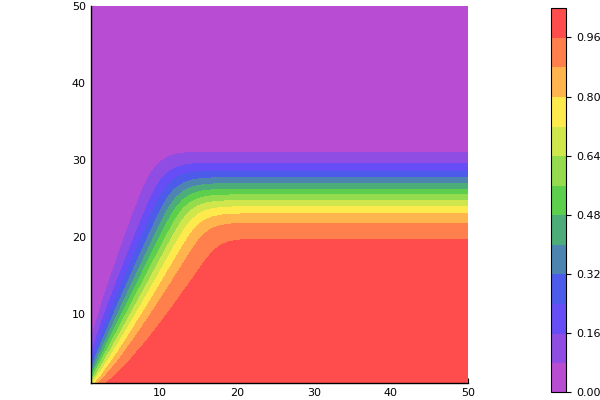

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _show(::Base64.Base64EncodePipe, ::MIME{Symbol("image/png")}, ::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:1343
└ @ Plots /home/furst/.julia/packages/Plots/QYETN/src/backends/pyplot.jl:1343
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _show(::Base64.Base64EncodePipe, ::MIME{Symbol("image/png")}, ::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:1343
└ @ Plots /home/furst/.julia/packages/Plots/QYETN/src/backends/pyplot.jl:1343


In [35]:
plot(reshape(u.values, 50,50), st=:contour, color=:lightrainbow, fill=true, aspect_ratio=:equal)

## Implicitní metoda

Implicitní metoda je výpočetně náročnější (v každém kroku řešíme soustavu rovnic), nicméně často bývá efektivnější neboť umožňuje použití delšího časového kroku. Pokusíme se naprogramovat implicitní metodu pro řešení **lineární** parciální diferenciální rovnice tak, že budeme jednotlivé operátory (derivace) reprezentovat jako trojici matice, neznámá a absolutní člen, tj.
$$
    L(x) = A x + b.
$$

In [36]:
using SparseArrays;

In [37]:
struct Equation
    A
    x
    b
end

S rovnicemi umíme provádět běžné operace 

In [38]:
# Scitani a odcitani rovnic 
for op ∈ [:+, :-]
    @eval begin
        function ($op)(e1::Equation, e2::Equation)
            @assert e1.x == e2.x
            Equation(($op)(e1.A, e2.A), e1.x, $(op)(e1.b, e2.b))
        end
    end
end

# Pricteni/odecteni pole o spravne velikosti 
for op ∈ [:+, :-]
    @eval begin
        function ($op)(e1::Equation, f::Array{Float64,1})
            @assert size(e1.x) == size(f)
            Equation(copy(e1.A), e1.x, $(op)(e1.b, f))
        end
    end
end

# Vynasobeni rovnice konstantou
*(a::Float64, eq::Equation) = Equation(a*eq.A, eq.x, a*eq.b);

Rovnice umíme vyřešit

In [39]:
function solve!(eqn::Equation)
    x = eqn.A \ eqn.b
    for i in eachindex(eqn.x)
        eqn.x[i] = -x[i]
    end
end;

### Operátor $\partial/\partial t$

Časovou derivaci aproximujeme jako
$$
    \frac{\partial u}{\partial t} \approx \frac{u^{n+1}-u^{n}}{\Delta t}
$$
tj. jako 
$$
T u^{n+1} + b
$$
kde $T=diag({1/\Delta t})$ a $b_i=- u_i^n/\Delta t$.

In [40]:
function ddt(f::Field,Δt)
    n = length(f.values)
    Equation(I/Δt, f.values, -f.values/Δt)
end;    

In [41]:
ddt(u3,0.1)

Equation(UniformScaling{Float64}
10.0*I, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0])

Zkusíme vyřešit soustavu ODE $\dot{u} = 1$ s počáteční podmínkou $u(0)-0$. Uděláme 10 kroků s $\Delta t=0.1$.

In [42]:
u3.values = zeros(9)
for t=1:10
    solve!(ddt(u3,0.1)-ones(9))
    print(u3.values[1], "\t")
end

0.1	0.2	0.3	0.39999999999999997	0.5	0.6	0.7	0.7999999999999999	0.9	1.0	

## Operátor $div(\vec{v}u)$

Operátor je reprezentován řídkou maticí a absolutním členem $b$. Matici sestavíme stejným způsobem jako při výpočtu $r_i$ explicitní metodou.

In [43]:
function div(v::Vector, u::Field)
    A = spzeros(length(u.values),length(u.values))
    b = zero(u.values)
    
    msh = u.mesh
    
    for f in internal_faces(msh)
        o = msh.owner[f]
        n = msh.neighbor[f]
        S = msh.surface[f]
        uo = u.values[o]
        un = u.values[n]
    
        ϕ = dot(v,S)
        α = max(ϕ, 0.0)
        β = min(ϕ, 0.0)
        
        A[o,o] += α / msh.volume[o]
        A[o,n] += β / msh.volume[o]
            
        A[n,o] -= α / msh.volume[n]
        A[n,n] -= β / msh.volume[n]
    end

    for p in boundary_patches(msh)
        name = msh.patch[p].name
        bc = u.boundaries[name]
        
        for f in patch_faces(msh, p)
            o = msh.owner[f]
            S = msh.surface[f]
            
            ϕ = dot(v,S)
            α = max(ϕ, 0.0)
            β = min(ϕ, 0.0)
            
            # ub = c1 + c2*u[o], flux=alpha*u[o] + beta*ub
            c1, c2 = boundary_coeffs(bc, f)

            A[o,o] += (α + β*c2) / msh.volume[o]
            b[o]   += β*c1 / msh.volume[o]
        end
    end
    
    return Equation(A, u.values, b)
end     

div (generic function with 1 method)

In [44]:
Matrix(div(v,u3).A)

9×9 Array{Float64,2}:
  4.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
 -3.0   4.5   0.0   0.0   0.0   0.0   0.0   0.0  0.0
  0.0  -3.0   4.5   0.0   0.0   0.0   0.0   0.0  0.0
 -1.5   0.0   0.0   4.5   0.0   0.0   0.0   0.0  0.0
  0.0  -1.5   0.0  -3.0   4.5   0.0   0.0   0.0  0.0
  0.0   0.0  -1.5   0.0  -3.0   4.5   0.0   0.0  0.0
  0.0   0.0   0.0  -1.5   0.0   0.0   4.5   0.0  0.0
  0.0   0.0   0.0   0.0  -1.5   0.0  -3.0   4.5  0.0
  0.0   0.0   0.0   0.0   0.0  -1.5   0.0  -3.0  4.5

### Vlastnosti matice $C$ reprezentující operátor $div(\vec{v}u)$

Nechť C je matice získaná reprezentující lineární operátor $div(\vec{v}u)$ získaná pomocí MKO a schématu **upwind**. Potom:
1. C je (neostře) diagonálně dominantní,
2. $C_{ii}>0$ a $C_{ij} \le 0$ pro $i\ne j$.
3. V řádcích odpovídajících vnitřním buňkám sítě (tj. ty, které nesousedí s žádnou hranicí) je $\sum_j C_{ij}=0$.

Vyřešíme rovnici konvekce do času $t=0.5s$ pomocí implicitní metody s krokem $\Delta t=0.05$

In [45]:
u.values = zero(u.values)

Δt = 0.05
for t=0:Δt:0.5
    solve!( ddt(u,Δt) + div(v,u) ); 
end

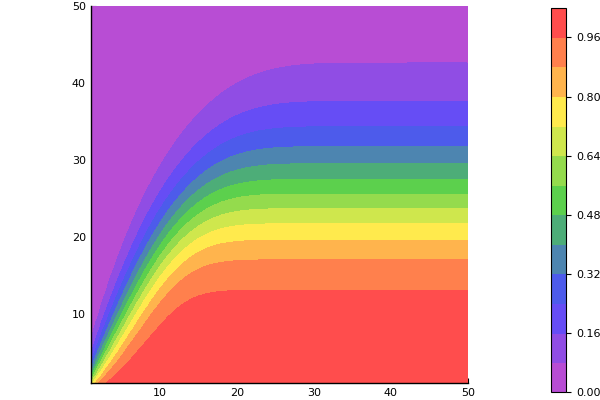

In [46]:
plot(reshape(u.values, 50,50), st=:contour, color=:lightrainbow, fill=true, aspect_ratio=:equal)

### Operátor $\Delta u$

Operátor $\Delta u$ je rozepsán jako $\Delta u = \nabla \cdot (\nabla u)$. Diskretizace se provede podobně jako u konvektivního členu. Tok $\nabla u \cdot \vec{S}$ je aproximován centrálně, tj.
$$
    \nabla u \cdot \vec{S} \approx ||\vec{S}|| \frac{u_n - u_o}{||\vec{x}_n-\vec{x}_o||}
$$
Zde se dopouštíme zjednodušení kdy předpokládáme, že vektor $\vec{S}$ je rovnoběžný s $\vec{x}_n - \vec{x}_o$ (ortogonalita sítě).

In [47]:
function Δ(μ::Float64, u::Field)
    mesh = u.mesh
    
    A = spzeros(length(u.values),length(u.values))
    b = zero(u.values)

    
    for f in internal_faces(mesh)
        o, n = mesh.owner[f], mesh.neighbor[f]
        xo, xn = mesh.centre[o], mesh.centre[n]
        S = mesh.surface[f]
        
        g = μ * norm(S) / norm(xn - xo)

        A[o,o] -= g / mesh.volume[o]
        A[o,n] += g / mesh.volume[o]
            
        A[n,o] += g / mesh.volume[n]
        A[n,n] -= g / mesh.volume[n]
    end
    
    
    for p in boundary_patches(mesh)
        name = mesh.patch[p].name
        bc = u.boundaries[name]
        
        for f in patch_faces(mesh, p)
            o = mesh.owner[f]
            S = mesh.surface[f]
            xo, xf = mesh.centre[o], mesh.facecentre[f]
            c1, c2 = boundary_coeffs(bc, f)
            
            # normal derivative at boundary dudn = (ub - uin) / delta
            # with ub = c[1] + c[2]*uin, i.e.
            # dudn = c[1]/delta + (c[2]-1)/delta*uin
            
            δ = dot(xf - xo, S)/norm(S)
            A[o,o] += μ * (c2-1)/δ * norm(S) / mesh.volume[o]
            b[o] += μ * c1/δ * norm(S) / mesh.volume[o]
        end
    end

    Equation(A, u.values, b)
end


Δ (generic function with 1 method)

### Vlastnosti matice $D$ reprezentující operátor $\Delta$

1. Matice $D$ je symetrická
2. Matice $D$ je neostře diagonálně dominantní
3. $D_{ii}<0$, $D_{ij} \ge 0$ pro $i\ne j$
4. Matice $-D$ je pozitivně definitní

In [48]:
D=Matrix(Δ(1.0,u3).A)

9×9 Array{Float64,2}:
 -54.0    9.0    0.0    9.0    0.0    0.0    0.0    0.0    0.0
   9.0  -45.0    9.0    0.0    9.0    0.0    0.0    0.0    0.0
   0.0    9.0  -36.0    0.0    0.0    9.0    0.0    0.0    0.0
   9.0    0.0    0.0  -45.0    9.0    0.0    9.0    0.0    0.0
   0.0    9.0    0.0    9.0  -36.0    9.0    0.0    9.0    0.0
   0.0    0.0    9.0    0.0    9.0  -27.0    0.0    0.0    9.0
   0.0    0.0    0.0    9.0    0.0    0.0  -36.0    9.0    0.0
   0.0    0.0    0.0    0.0    9.0    0.0    9.0  -27.0    9.0
   0.0    0.0    0.0    0.0    0.0    9.0    0.0    9.0  -18.0

## Řešení rovnice konvekce s difuzí pomocí MKO

V každém kroku se řeší soustava rovnic s maticí
$A = T + C - D$. Tato matice je:
1. nesymetrická,
2. ODD,
3. $A_{ii}>0$, $A_{ij} \le 0$ pro $i \ne j$,
4. $\sum_j A_{ij} \le 1/\Delta t$.

In [49]:
A = Matrix((ddt(u3,Δt) + div(v,u3) - Δ(1.e-1,u3)).A)

9×9 Array{Float64,2}:
 29.9  -0.9   0.0  -0.9   0.0   0.0   0.0   0.0   0.0
 -3.9  29.0  -0.9   0.0  -0.9   0.0   0.0   0.0   0.0
  0.0  -3.9  28.1   0.0   0.0  -0.9   0.0   0.0   0.0
 -2.4   0.0   0.0  29.0  -0.9   0.0  -0.9   0.0   0.0
  0.0  -2.4   0.0  -3.9  28.1  -0.9   0.0  -0.9   0.0
  0.0   0.0  -2.4   0.0  -3.9  27.2   0.0   0.0  -0.9
  0.0   0.0   0.0  -2.4   0.0   0.0  28.1  -0.9   0.0
  0.0   0.0   0.0   0.0  -2.4   0.0  -3.9  27.2  -0.9
  0.0   0.0   0.0   0.0   0.0  -2.4   0.0  -3.9  26.3

Řešení dané úlohy pro čas $t=0.5s$ pomocí implicitní metody s krokem $\Delta t = 0.1s$ s nulovou počáteční podmínkou.

In [50]:
u.values = zero(u.values)

Δt = 0.1
for t=0:Δt:0.5
    solve!( ddt(u,Δt) + div(v,u) - Δ(1.e-2,u) ); 
end

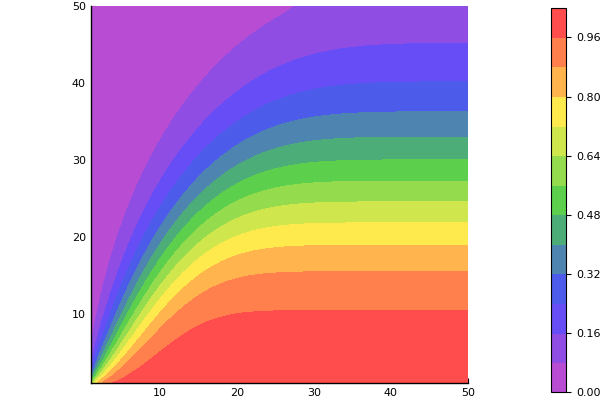

In [51]:
plot(reshape(u.values, 50,50), st=:contour, color=:lightrainbow, fill=true, aspect_ratio=:equal)